#Library

In [ ]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 3.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from google.colab import files

In [ ]:
uploaded = files.upload()

KeyboardInterrupt: 

# Data Import

In [ ]:
train_df = pd.read_excel('Project2_Training.xlsx')
test_df = pd.read_excel('Project2_Test.xlsx')
train_df.shape, test_df.shape

((101891, 26), (15114, 25))

Now combine training and testing data together, but as the column names are not uniform, fix the columns name first.

In [ ]:
train_df['data_source'] = 'train'
test_df['data_source'] = 'test'
test_df = test_df.rename(columns={'ANNUALKM': 'ANNUAL_KM',
                                  'COMMUTEDISTANCE': 'COMMUTE_DISTANCE',
                                  'MARKINGSYSTEM': 'MARKING_SYSTEM',
                                  'TRACKINGSYSTEM':'TRACKING_SYSTEM',
                                  'VEHICLEOWNERSHIP':'VEHICLE_OWNERSHIP',
                                  'VEHICLEVALUE':'VEHICLE_VALUE',
                                  'YEAROFBIRTH':'YEAR_OF_BIRTH',
                                  'POSTALCODE':'POSTAL_CODE',
                                  'AREACODE':'AREA_CODE',
                                  'YEARSLICENSED':'YEARS_LICENSED',
                                  'YEARSASPRINCIPALDRIVER':'YEARS_AS_PRINCIPAL_DRIVER',
                                  'MULTIPRODUCT':'MULTI_PRODUCT',
                                  'MARITALSTATUS':'MARITAL_STATUS',
                                  'CONVICTIONCOUNTMINOR3YRS':'CONVICTION_COUNT_MINOR_3YRS',
                                  'CONVICTIONCOUNTMAJOR3YRS':'CONVICTION_COUNT_MAJOR_3YRS',
                                  'CONVICTIONCOUNTCRIMINAL3YRS':'CONVICTION_COUNT_CRIMINAL_3YRS',
                                  'ASSIGNEDLOSSESPD5YRS':'ASSIGNED_LOSSES_PD_5YRS',
                                  'SUSPENSIONCOUNT': 'SUSPENSION_COUNT'
                                  })

## Data Processing

In [ ]:
whole_df = pd.concat([train_df, test_df])
whole_df.head()

,QUOTEDATE,VEHICLEYEAR,VEHICLEMAKE,VEHICLEMODEL,ANNUAL_KM,COMMUTE_DISTANCE,MARKING_SYSTEM,TRACKING_SYSTEM,VEHICLE_OWNERSHIP,VEHICLE_VALUE,...,MULTI_PRODUCT,MARITAL_STATUS,OCCUPATION,CONVICTION_COUNT_MINOR_3YRS,CONVICTION_COUNT_MAJOR_3YRS,CONVICTION_COUNT_CRIMINAL_3YRS,ASSIGNED_LOSSES_PD_5YRS,SUSPENSION_COUNT,IS_BOUND,data_source
0,2016-01-02,2006,VOLKSWAGEN,JETTA 2.5 4P,10000.0,NaN,NaN,NaN,Owned,3000.0,...,No,Married,Trades,0,0,0,0,0,0.0,train
1,2016-01-02,2017,HYUNDAI,ELANTRA GL 4DR,20000.0,NaN,NaN,NaN,Owned,1.0,...,No,Married,Not Known,0,0,0,0,0,0.0,train
2,2016-01-02,2015,CHEVROLET TRUCK/VAN,SILVERADO 2500 HD LT CREW CAB 4WD,15000.0,NaN,NaN,NaN,NaN,NaN,...,No,Single,Not Known,0,0,0,0,0,0.0,train
3,2016-01-02,2010,TOYOTA,COROLLA CE 4DR,20000.0,20.0,NaN,NaN,NaN,NaN,...,Yes,Single,Not Known,0,0,0,0,0,0.0,train
4,2016-01-04,2013,HONDA,CIVIC LX 4DR,30000.0,30.0,NaN,NaN,NaN,NaN,...,Yes,Single,Not Known,0,0,0,0,0,0.0,train


Check for missing values.

In [ ]:
whole_df.groupby('data_source').apply(lambda x: x.isna().sum()[x.isna().sum() > 0])

<ipython-input-6-10ae0d35c2b7>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  whole_df.groupby('data_source').apply(lambda x: x.isna().sum()[x.isna().sum() > 0])


data_source                           
test         COMMUTE_DISTANCE               5191
             MARKING_SYSTEM                15095
             TRACKING_SYSTEM               15112
             VEHICLE_OWNERSHIP             11500
             VEHICLE_VALUE                 10159
             YEARS_LICENSED                    3
             YEARS_AS_PRINCIPAL_DRIVER     14946
             IS_BOUND                      15114
train        ANNUAL_KM                         1
             COMMUTE_DISTANCE              35413
             MARKING_SYSTEM               101866
             TRACKING_SYSTEM              101887
             VEHICLE_OWNERSHIP             76450
             VEHICLE_VALUE                 64673
             GENDER                            5
             YEARS_LICENSED                    8
             YEARS_AS_PRINCIPAL_DRIVER    101279
             OCCUPATION                        1
dtype: int64

We can tell that Marking_System and Tracking system are having over 90 % missing values, so check if those existing values are having significant impact.

In [ ]:
unique_marking_system_train = train_df['MARKING_SYSTEM'].unique()
unique_marking_system_test = test_df['MARKING_SYSTEM'].unique()
unique_marking_system_train, unique_marking_system_test

(array([nan, 'M - Sherlock Marking', 'M - Autolock Marking',
        'M - Vin-Lock Marking'], dtype=object),
 array([nan, 'M - Sherlock Marking', 'M - Vin-Lock Marking',
        'M - Autoluck Marking'], dtype=object))

In [ ]:
# mapping = {'M - Autolock Marking': 1, 'M - Sherlock Marking': 2, 'M - Vin-Lock Marking': 3}
train_df['MARKING_SYSTEM'] = train_df['MARKING_SYSTEM'].fillna(0)
count_summary_marking_system = train_df.groupby('MARKING_SYSTEM')['IS_BOUND'].value_counts().unstack(fill_value=0)
count_summary_marking_system

IS_BOUND,0,1
MARKING_SYSTEM,,
0,79579,22287
M - Autolock Marking,2,0
M - Sherlock Marking,18,4
M - Vin-Lock Marking,0,1


In [ ]:
train_df['TRACKING_SYSTEM'] = train_df['TRACKING_SYSTEM'].fillna(0)
count_summary_tracking_system = train_df.groupby('TRACKING_SYSTEM')['IS_BOUND'].value_counts().unstack(fill_value=0)
count_summary_tracking_system

IS_BOUND,0,1
TRACKING_SYSTEM,,
0,79595,22292
R - Boomerang Espion Alerte,1,0
R - Boomerang Espion Alerte Plus - Lojack,1,0
R - SurtraQ,1,0
R - TAG,1,0


From this output, i cannnot see a significant effect of the MARKING_SYSTEM and TRACKING_SYSTEM and as there's only a handful of the data are not missing, thus i would just delete the MARKING_SYSTEM and TRACKING_SYSTEM columns.

In [ ]:
whole_df = whole_df.drop(['MARKING_SYSTEM', 'TRACKING_SYSTEM'], axis=1)
whole_df.groupby('data_source').apply(lambda x: x.isna().sum()[x.isna().sum() > 0])


<ipython-input-10-8ea44869f6a6>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  whole_df.groupby('data_source').apply(lambda x: x.isna().sum()[x.isna().sum() > 0])


data_source                           
test         COMMUTE_DISTANCE               5191
             VEHICLE_OWNERSHIP             11500
             VEHICLE_VALUE                 10159
             YEARS_LICENSED                    3
             YEARS_AS_PRINCIPAL_DRIVER     14946
             IS_BOUND                      15114
train        ANNUAL_KM                         1
             COMMUTE_DISTANCE              35413
             VEHICLE_OWNERSHIP             76450
             VEHICLE_VALUE                 64673
             GENDER                            5
             YEARS_LICENSED                    8
             YEARS_AS_PRINCIPAL_DRIVER    101279
             OCCUPATION                        1
dtype: int64

Looking at VEHICLE_OWNERSHIP

In [ ]:
train_df['VEHICLE_OWNERSHIP'] = train_df['VEHICLE_OWNERSHIP'].fillna(0)
count_summary_vehicle_ownership = train_df.groupby('VEHICLE_OWNERSHIP')['IS_BOUND'].value_counts().unstack(fill_value=0)
count_summary_vehicle_ownership
whole_df[whole_df['data_source'] == 'test'].shape

(15114, 25)

In [ ]:
count_summary_vehicle_ownership['sum_0_1'] = count_summary_vehicle_ownership[0] + count_summary_vehicle_ownership[1]
count_summary_vehicle_ownership['ratio'] = count_summary_vehicle_ownership[1] / count_summary_vehicle_ownership['sum_0_1']
count_summary_vehicle_ownership

IS_BOUND,0,1,sum_0_1,ratio
VEHICLE_OWNERSHIP,,,,
0,59634,16816,76450,0.219961
Leased,1854,493,2347,0.210055
Non-owned,84,20,104,0.192308
Owned,18027,4963,22990,0.215876


As the distribution is mostly the same, i will also delete the vehicle_ownership column.

In [ ]:
whole_df = whole_df.drop(['VEHICLE_OWNERSHIP'], axis=1)
whole_df.groupby('data_source').apply(lambda x: x.isna().sum()[x.isna().sum() > 0])
whole_df[whole_df['data_source'] == 'test'].shape

<ipython-input-13-ad38fa9e1a7c>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  whole_df.groupby('data_source').apply(lambda x: x.isna().sum()[x.isna().sum() > 0])


(15114, 24)

Now look at the Years_as_principle_driver. As there are too many missing data in the test set, which means, even if we include the years_as_principal_driver in the training model, we can still not use it in the test case.Thus, we will simply delete the column.

In [ ]:
whole_df = whole_df.drop(['YEARS_AS_PRINCIPAL_DRIVER'], axis=1)
whole_df.groupby('data_source').apply(lambda x: x.isna().sum()[x.isna().sum() > 0])

<ipython-input-14-2d98a0aa1754>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  whole_df.groupby('data_source').apply(lambda x: x.isna().sum()[x.isna().sum() > 0])


data_source                  
test         COMMUTE_DISTANCE     5191
             VEHICLE_VALUE       10159
             YEARS_LICENSED          3
             IS_BOUND            15114
train        ANNUAL_KM               1
             COMMUTE_DISTANCE    35413
             VEHICLE_VALUE       64673
             GENDER                  5
             YEARS_LICENSED          8
             OCCUPATION              1
dtype: int64

Now check the column of Vehicle_value,


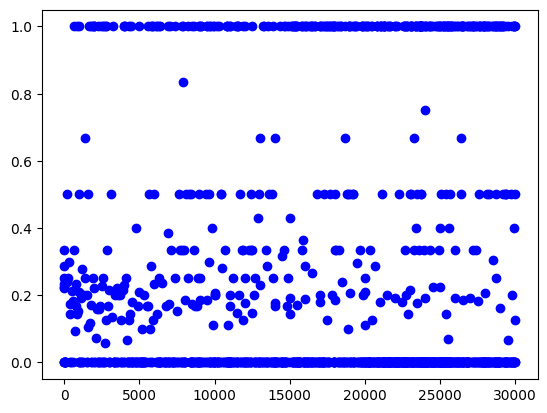

In [ ]:
train_df['VEHICLE_VALUE'] = train_df['VEHICLE_VALUE'].fillna(0)
count_summary_vehicle_value = train_df.groupby('VEHICLE_VALUE')['IS_BOUND'].value_counts().unstack(fill_value=0)
count_summary_vehicle_value
count_summary_vehicle_value['sum_0_1'] = count_summary_vehicle_value[0] + count_summary_vehicle_value[1]
count_summary_vehicle_value['ratio'] = count_summary_vehicle_value[1] / count_summary_vehicle_value['sum_0_1']
count_summary_vehicle_value
count_summary_vehicle_value = count_summary_vehicle_value.reset_index()
count_summary_vehicle_value = count_summary_vehicle_value[count_summary_vehicle_value['VEHICLE_VALUE'] < 30000]

plt.scatter(count_summary_vehicle_value['VEHICLE_VALUE'], count_summary_vehicle_value['ratio'], color='blue', marker='o')

As theres no pattern at all, i will just leave this column away.

ValueError: cannot reindex on an axis with duplicate labels

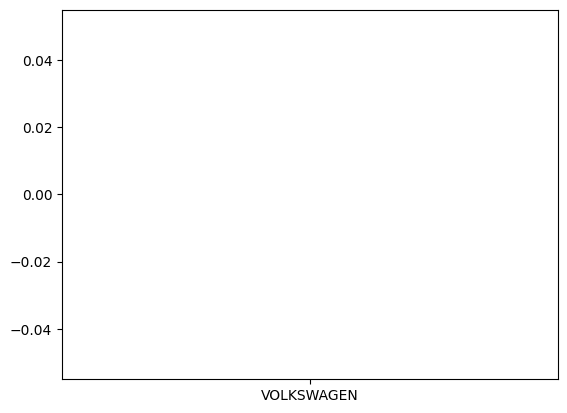

In [ ]:
sns.boxplot(x='VEHICLEMAKE', y='VEHICLE_VALUE', data=whole_df)

In [ ]:
# whole_df = whole_df.drop(['VEHICLE_VALUE'], axis=1)
# whole_df.groupby('data_source').apply(lambda x: x.isna().sum()[x.isna().sum() > 0])
# whole_df[whole_df['data_source'] == 'test'].shape
mean_values = whole_df.groupby('VEHICLEMODEL')['VEHICLE_VALUE'].transform('median')
whole_df['VEHICLE_VALUE'] = whole_df['VEHICLE_VALUE'].fillna(mean_values)
mean_values = whole_df.groupby('VEHICLEMAKE')['VEHICLE_VALUE'].transform('median')
whole_df['VEHICLE_VALUE'] = whole_df['VEHICLE_VALUE'].fillna(mean_values)
mean_values = whole_df.groupby('POSTAL_CODE')['VEHICLE_VALUE'].transform('median')
whole_df['VEHICLE_VALUE'] = whole_df['VEHICLE_VALUE'].fillna(mean_values)
whole_df.groupby('data_source').apply(lambda x: x.isna().sum()[x.isna().sum() > 0])

<ipython-input-38-c73e9352c83e>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  whole_df.groupby('data_source').apply(lambda x: x.isna().sum()[x.isna().sum() > 0])


data_source                  
test         COMMUTE_DISTANCE     5191
             YEARS_LICENSED          3
             IS_BOUND            15114
train        ANNUAL_KM               1
             COMMUTE_DISTANCE    35413
             GENDER                  5
             YEARS_LICENSED          8
             OCCUPATION              1
dtype: int64

Look at the commute distance

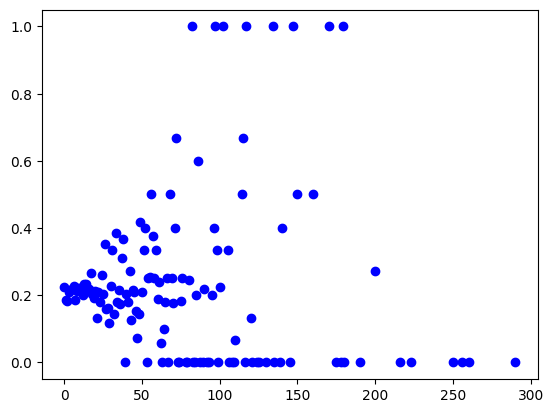

In [ ]:
train_df['COMMUTE_DISTANCE'] = train_df['COMMUTE_DISTANCE'].fillna(0)
count_summary_commute_distance = train_df.groupby('COMMUTE_DISTANCE')['IS_BOUND'].value_counts().unstack(fill_value=0)
count_summary_commute_distance
count_summary_commute_distance['sum_0_1'] = count_summary_commute_distance[0] + count_summary_commute_distance[1]
count_summary_commute_distance['ratio'] = count_summary_commute_distance[1] / count_summary_commute_distance['sum_0_1']
count_summary_commute_distance
count_summary_commute_distance = count_summary_commute_distance.reset_index()
count_summary_commute_distance = count_summary_commute_distance[count_summary_commute_distance['COMMUTE_DISTANCE'] < 300]

plt.scatter(count_summary_commute_distance['COMMUTE_DISTANCE'], count_summary_commute_distance['ratio'], color='blue', marker='o')

We can tell that the vehicle is more likely be rejected if commute distance is greater than 100, thus , i will keep this column.

NOW, remove the rows in training data set that has those unusual data.

consider annual_KM between 1000 and 100000 km
age between 16 - 100
years_licensed < age - 16

In [ ]:
print(whole_df[whole_df['data_source'] == 'test'].shape)
train_df = whole_df[whole_df['data_source'] == 'train']
test_df = whole_df[whole_df['data_source'] == 'test']

train_df = train_df.drop(
    train_df[
        (train_df['COMMUTE_DISTANCE'] > 300) |
        (train_df['ANNUAL_KM'] < 1000) |
        (train_df['ANNUAL_KM'] > 100000) |
        (train_df['YEAR_OF_BIRTH'] > 2000) |
        (train_df['YEAR_OF_BIRTH'] < 1916) |
        (train_df['YEARS_LICENSED'] > 2000 - train_df['YEAR_OF_BIRTH'])
    ].index
)


whole_df = pd.concat([train_df, test_df])
print(whole_df[whole_df['data_source'] == 'test'].shape)

(15114, 23)
(15114, 23)


Now, we can start to dealing with columns which contain missing values.

In [ ]:
na_columns = whole_df.columns[whole_df.isna().any()].tolist()
na_columns

['ANNUAL_KM', 'COMMUTE_DISTANCE', 'YEARS_LICENSED', 'IS_BOUND']

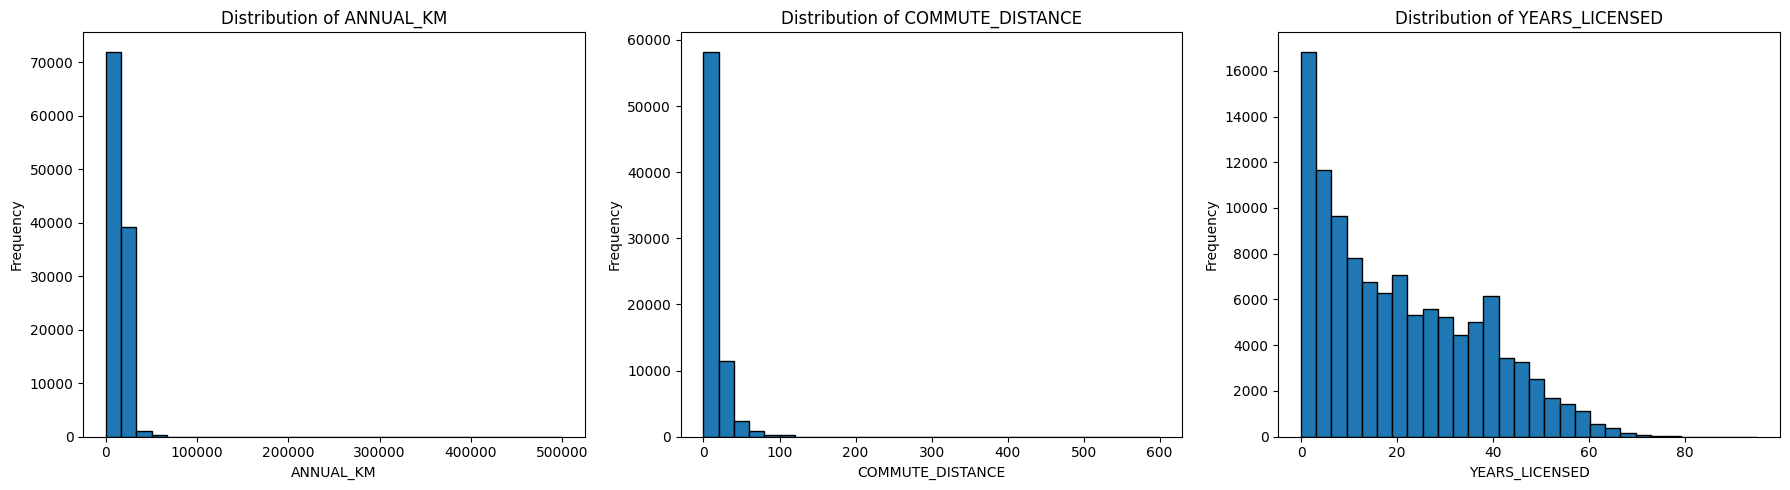

In [ ]:
plt.figure(figsize=(18, 5))

# 'ANNUAL_KM' distribution plot
plt.subplot(1, 3, 1)  # 1 行 3 列的布局，第一张图
plt.hist(whole_df['ANNUAL_KM'].dropna(), bins=30, edgecolor='k')
plt.title('Distribution of ANNUAL_KM')
plt.xlabel('ANNUAL_KM')
plt.ylabel('Frequency')

# 'COMMUTE_DISTANCE' distribution plot
plt.subplot(1, 3, 2)  # 1 行 3 列的布局，第二张图
plt.hist(whole_df['COMMUTE_DISTANCE'].dropna(), bins=30, edgecolor='k')
plt.title('Distribution of COMMUTE_DISTANCE')
plt.xlabel('COMMUTE_DISTANCE')
plt.ylabel('Frequency')

# 'YEARS_LICENSED' distribution plot
plt.subplot(1, 3, 3)  # 1 行 3 列的布局，第三张图
plt.hist(whole_df['YEARS_LICENSED'].dropna(), bins=30, edgecolor='k')
plt.title('Distribution of YEARS_LICENSED')
plt.xlabel('YEARS_LICENSED')
plt.ylabel('Frequency')

# show plot
plt.tight_layout()
plt.show()

Since 'IS_BOUND' is our response variable and the NA values in this columns are belong to test dataset. Thus, we can just ignore this variable and focus on first three variables. By plotting out the distributions of these three columns, we can see that all of them are like right-skewed distribution rather than normal distribution. In this case, median imputation would be better than mean imputation since it won't be influenced by extreme values.

In [ ]:
median_values = whole_df.groupby('YEAR_OF_BIRTH')['YEARS_LICENSED'].transform('median')
whole_df['YEARS_LICENSED'] = whole_df['YEARS_LICENSED'].fillna(median_values)
median_values = whole_df.groupby('COMMUTE_DISTANCE')['ANNUAL_KM'].transform('median')
whole_df['ANNUAL_KM'] = whole_df['ANNUAL_KM'].fillna(median_values)
median_values = whole_df.groupby('POSTAL_CODE')['COMMUTE_DISTANCE'].transform('median')
whole_df['COMMUTE_DISTANCE'] = whole_df['COMMUTE_DISTANCE'].fillna(median_values)
median_values = whole_df.groupby("ANNUAL_KM")['COMMUTE_DISTANCE'].transform('median')
whole_df['COMMUTE_DISTANCE'] = whole_df['COMMUTE_DISTANCE'].fillna(median_values)
whole_df.groupby('data_source').apply(lambda x: x.isna().sum()[x.isna().sum() > 0])
whole_df[whole_df['data_source'] == 'test'].shape

<ipython-input-42-99deb885bca1>:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  whole_df.groupby('data_source').apply(lambda x: x.isna().sum()[x.isna().sum() > 0])


(15114, 23)

In [ ]:
na_columns = whole_df.columns[whole_df.isna().any()].tolist()
na_columns

['IS_BOUND']

In [ ]:
whole_df.groupby('data_source').apply(lambda x: x.isna().sum()[x.isna().sum() > 0])


<ipython-input-44-10ae0d35c2b7>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  whole_df.groupby('data_source').apply(lambda x: x.isna().sum()[x.isna().sum() > 0])


,,0
data_source,,
test,IS_BOUND,15114


## Data Encoding

In [ ]:
# 找到所有类别型列
categorical_columns = whole_df.select_dtypes(include=['object', 'category']).columns

# 打印每个类别型列的唯一值
for col in categorical_columns:
    unique_values = whole_df[col].unique()
    print(f"Column: {col}")
    print("Total unique values:", len(unique_values))
    print("-" * 40)

Column: VEHICLEMAKE
Total unique values: 270
----------------------------------------
Column: VEHICLEMODEL
Total unique values: 6008
----------------------------------------
Column: VEHICLEUSE
Total unique values: 11
----------------------------------------
Column: GENDER
Total unique values: 3
----------------------------------------
Column: POSTAL_CODE
Total unique values: 1175
----------------------------------------
Column: AREA_CODE
Total unique values: 211
----------------------------------------
Column: MULTI_PRODUCT
Total unique values: 2
----------------------------------------
Column: MARITAL_STATUS
Total unique values: 6
----------------------------------------
Column: OCCUPATION
Total unique values: 19
----------------------------------------
Column: data_source
Total unique values: 2
----------------------------------------


By summary, we can list all categorical columns and the number of possible values in each column. First, we can just encoding those columns which only have few possible values, like 'VEHICLEUSE', 'GENDER', by using one-hot encoding.

In [ ]:
whole_df = pd.get_dummies(whole_df, columns=['VEHICLEUSE', 'GENDER', 'MULTI_PRODUCT', 'MARITAL_STATUS', 'OCCUPATION'], drop_first=True)


In [ ]:
for column in ['VEHICLEMAKE','VEHICLEMODEL','POSTAL_CODE', 'AREA_CODE']:
    frequency_encoding = whole_df[column].value_counts() / len(whole_df)
    whole_df[column] = whole_df[column].map(frequency_encoding)

In [ ]:
# whole_df = pd.get_dummies(whole_df, columns=['VEHICLEMAKE','VEHICLEMODEL','POSTAL_CODE', 'AREA_CODE'], drop_first=True)
# train_df = whole_df[whole_df['data_source'] == 'train']
# test_df = whole_df[whole_df['data_source'] == 'test']

# train_df.shape, test_df.shape

((97501, 7709), (15114, 7709))

Now, we need to deal with these columns that contain many possible values. By searching online, we choose Target Encoding approach to encode these columns. One thing we should notice here is target leakage which means our model will be overfitting since some features may contain information that directly related with our response variable. By checking the features that we gonna encode, we believe these features don't include any information like that.

In [ ]:
# target_encoder = ce.TargetEncoder(cols=['VEHICLEMAKE', 'VEHICLEMODEL', 'POSTAL_CODE', 'AREA_CODE'])
# whole_df[whole_df['data_source'] == 'train'] = target_encoder.fit_transform(whole_df[whole_df['data_source'] == 'train'], whole_df.loc[whole_df['data_source'] == 'train', 'IS_BOUND'])

In [ ]:
train_df = whole_df[whole_df['data_source'] == 'train']
test_df = whole_df[whole_df['data_source'] == 'test']

train_df.drop('data_source', axis=1, inplace=True)
test_df.drop(['data_source', 'IS_BOUND'], axis=1, inplace=True)

<ipython-input-47-3945dcaa163e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop('data_source', axis=1, inplace=True)
<ipython-input-47-3945dcaa163e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(['data_source', 'IS_BOUND'], axis=1, inplace=True)


In [ ]:
# 定义目标编码函数
def target_encode(X, column_name, target_mean):
    return X[column_name].map(target_mean)

for column in ['VEHICLEMAKE', 'VEHICLEMODEL', 'POSTAL_CODE', 'AREA_CODE']:
    target_mean = train_df.groupby(column)['IS_BOUND'].mean()
    train_df[column] = target_encode(train_df, column, target_mean)
    test_df[column] = target_encode(test_df, column, target_mean)


train_df['VEHICLEMAKE'], test_df['VEHICLEMAKE']

<ipython-input-50-b08a759030de>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[column] = target_encode(train_df, column, target_mean)
<ipython-input-50-b08a759030de>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[column] = target_encode(test_df, column, target_mean)


(0         0.239716
 1         0.210330
 2         0.232995
 3         0.193894
 4         0.197632
             ...   
 101886    0.216738
 101887    0.197632
 101888    0.217391
 101889    0.238501
 101890    0.231673
 Name: VEHICLEMAKE, Length: 97501, dtype: float64,
 0        0.197632
 1        0.237739
 2        0.228502
 3        0.228502
 4        0.232571
            ...   
 15109    0.197632
 15110    0.225040
 15111    0.203628
 15112    0.203628
 15113    0.210330
 Name: VEHICLEMAKE, Length: 15114, dtype: float64)

In [ ]:
test_df.apply(lambda x: x.isna().sum()[x.isna().sum() > 0])
for column in ['VEHICLEMAKE', 'VEHICLEMODEL', 'POSTAL_CODE', 'AREA_CODE']:
  test_df[column] = test_df[column].fillna(0)

train_df.shape, test_df.shape

<ipython-input-51-46c74bb0016b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[column] = test_df[column].fillna(0)


((97501, 53), (15114, 52))

In [ ]:
def calculate_profit(y_true, y_pred):
    profit = 0
    for yt, yp in zip(y_true, y_pred):
        if yp == 1:
            if yt == 1:
                profit += 4.5  # 赚取净利润
            else:
                profit -= 1  # 亏损
    return profit


# Logistic Regression

In [ ]:
# 假设 IS_BOUND 是目标列，将它与特征分开
X = train_df.drop(columns=['IS_BOUND'])  # 特征数据
X = X.drop(columns=['QUOTEDATE'], errors = 'ignore') # 删除时间列
y = train_df['IS_BOUND']  # 目标列

# 划分训练集和验证集，80% 训练，20% 验证
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 初始化逻辑回归模型
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')  # max_iter 用于确保收敛

# 在训练集上训练模型
log_reg.fit(X_train, y_train)

# 在验证集上预测
y_pred = log_reg.predict(X_val)

# 计算准确率
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.2f}")

# 混淆矩阵
conf_matrix = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# 分类报告
class_report = classification_report(y_val, y_pred)
print("Classification Report:\n", class_report)

Validation Accuracy: 0.62
Confusion Matrix:
 [[9218 5818]
 [1539 2686]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.61      0.71     15036
         1.0       0.32      0.64      0.42      4225

    accuracy                           0.62     19261
   macro avg       0.59      0.62      0.57     19261
weighted avg       0.74      0.62      0.65     19261



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Plot ROC curve for logistic regression model

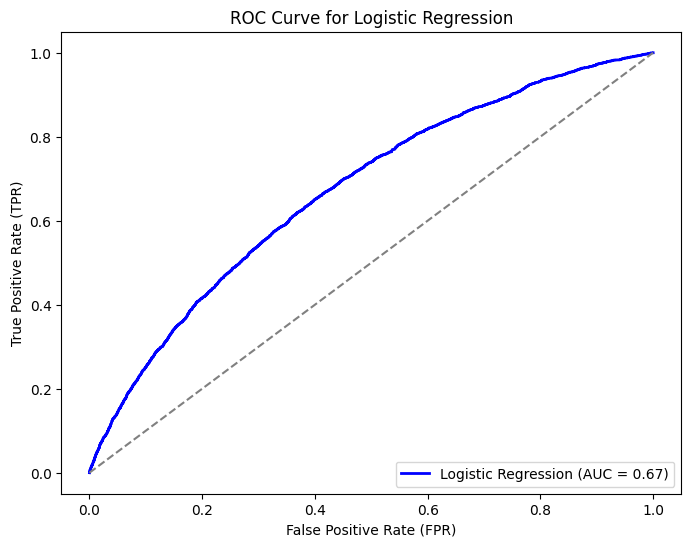

In [ ]:
y_pred_proba_log_reg = log_reg.predict_proba(X_val)[:, 1]  # 获取正类的预测概率

# 计算 ROC 曲线和 AUC 值
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_val, y_pred_proba_log_reg)
roc_auc_log_reg = auc(fpr_log_reg, tpr_log_reg)

# 绘制 ROC 曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr_log_reg, tpr_log_reg, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_log_reg:.2f})')

# 绘制对角线（随机猜测的 ROC 曲线）
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# 添加图例和标签
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc='lower right')
plt.show()

# Navie Bayes

## Multinomial Naive Bayes

In [ ]:
nb_model = MultinomialNB()

# 假设 IS_BOUND 是目标列，将它与特征分开
X = train_df.drop(columns=['IS_BOUND'])  # 特征数据
X = X.drop(columns=['QUOTEDATE'], errors = 'ignore') # 删除时间列
y = train_df['IS_BOUND']  # 目标列

# 划分训练集和验证集，80% 训练，20% 验证
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 在训练集上训练模型
nb_model.fit(X_train, y_train)

# 在验证集上进行预测
y_pred = nb_model.predict(X_val)

# 评估模型效果
print(f"Validation Accuracy: {accuracy_score(y_val, y_pred):.2f}")
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))

Validation Accuracy: 0.53
Confusion Matrix:
 [[8280 6756]
 [2286 1939]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.78      0.55      0.65     15036
         1.0       0.22      0.46      0.30      4225

    accuracy                           0.53     19261
   macro avg       0.50      0.50      0.47     19261
weighted avg       0.66      0.53      0.57     19261



Plot ROC curve for Naive Bayes

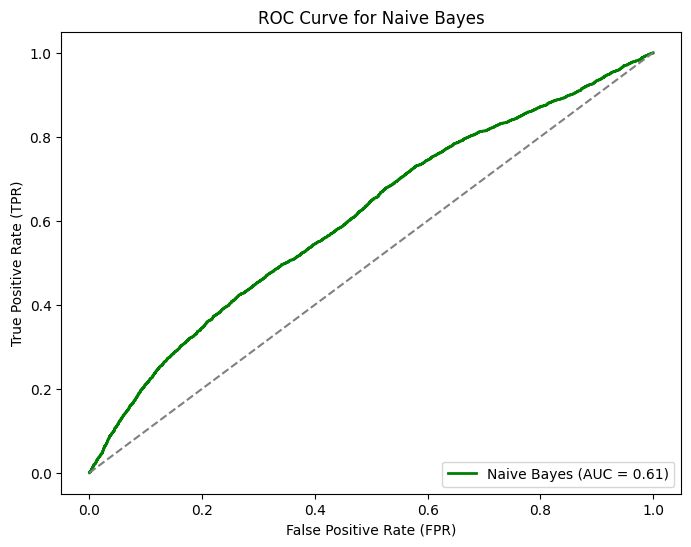

In [ ]:
y_pred_proba_nb = nb_model.predict_proba(X_val)[:, 1]  # 获取正类的预测概率

# 计算 ROC 曲线和 AUC 值
fpr_nb, tpr_nb, _ = roc_curve(y_val, y_pred_proba_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)

# 绘制 ROC 曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr_nb, tpr_nb, color='green', lw=2, label=f'Naive Bayes (AUC = {roc_auc_nb:.2f})')

# 绘制对角线（随机猜测的 ROC 曲线）
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# 添加图例和标签
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Naive Bayes')
plt.legend(loc='lower right')
plt.show()

# Random Forests


In [ ]:
X = train_df.drop(columns=['IS_BOUND'])  # 特征数据
X = X.drop(columns=['QUOTEDATE'], errors = 'ignore') # 删除时间列
y = train_df['IS_BOUND']  # 目标列
X_test = test_df.drop(columns=['QUOTEDATE','IS_BOUND'], errors = 'ignore')
print(X_test.shape)
print(len(X_test))

# 划分训练集和验证集，80% 训练，20% 验证
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=66)

# 创建决策树分类器
clf = DecisionTreeClassifier(random_state=66)

# 训练模型
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
y_true = y_val
cm = confusion_matrix(y_true, y_pred)
print(cm)



y_final = clf.predict(X_test)
print(len(y_final))
y_final = y_final.tolist()

print(y_final)

(15114, 50)
15114
[[11812  3385]
 [ 2962  1342]]
15114
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0,

In [ ]:
# 假设 y_final 已经是预测结果
test_df['IS_BOUND'] = y_final  # 将 y_final 列表赋值给 IS_BOUND 列

# 根据条件更新 IS_BOUND 列的值
test_df.loc[
    (test_df['COMMUTE_DISTANCE'] > 300) |
    (test_df['ANNUAL_KM'] < 1000) |
    (test_df['ANNUAL_KM'] > 100000) |
    (test_df['YEAR_OF_BIRTH'] > 2000) |
    (test_df['YEAR_OF_BIRTH'] < 1916) |
    (test_df['YEARS_LICENSED'] > 2000 - test_df['YEAR_OF_BIRTH']),
    'IS_BOUND'
] = 0

# 打印 IS_BOUND 列
print(test_df['IS_BOUND'].tolist())


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,

<ipython-input-27-3014e74eac76>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['IS_BOUND'] = y_final  # 将 y_final 列表赋值给 IS_BOUND 列


# RANDOM FOREST

[[17465  5265]
 [ 4849  1672]]
[[21186  1544]
 [ 6015   506]]
[[19248  3482]
 [ 5379  1142]]
[[21316  1414]
 [ 6042   479]]
[[20140  2590]
 [ 5599   922]]
[[21522  1208]
 [ 6060   461]]
[[20715  2015]
 [ 5762   759]]
[[21666  1064]
 [ 6117   404]]
[[21043  1687]
 [ 5909   612]]
[[21775   955]
 [ 6157   364]]
[[21329  1401]
 [ 5969   552]]
[[21876   854]
 [ 6192   329]]
[[21486  1244]
 [ 6039   482]]
[[21945   785]
 [ 6206   315]]
[[21647  1083]
 [ 6073   448]]
[[21990   740]
 [ 6218   303]]
[[21718  1012]
 [ 6113   408]]
[[22020   710]
 [ 6225   296]]
[[21776   954]
 [ 6120   401]]
[[22048   682]
 [ 6236   285]]


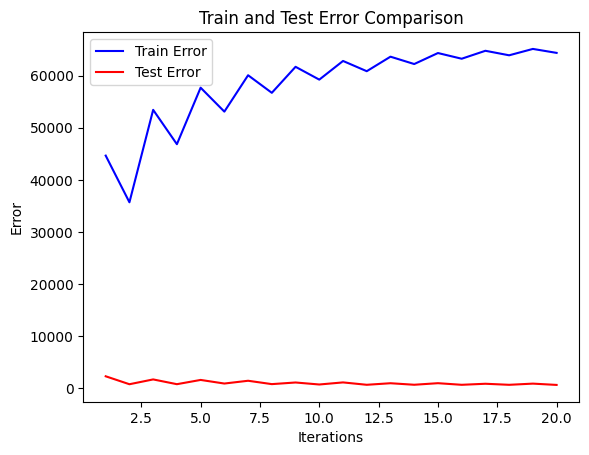

In [ ]:
X = train_df.drop(columns=['IS_BOUND'])  # 特征数据
X = X.drop(columns=['QUOTEDATE'], errors = 'ignore') # 删除时间列
y = train_df['IS_BOUND']  # 目标列
Final_test = test_df.drop(columns=['QUOTEDATE','IS_BOUND'], errors = 'ignore')
# 将数据集拆分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=66)

test_error = []
train_error = []
for i in range(1,21):
  clf = RandomForestClassifier(n_estimators=i, random_state=66)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  accuracy = income_total(y_test,y_pred)
  test_error.append(accuracy)
  cm = confusion_matrix(y_true, y_pred)
  print(cm)
  y_pred = clf.predict(X_train)
  accuracy = income_total(y_train,y_pred)
  train_error.append(accuracy)


x = list(range(1, 21))

# 绘制两条线
plt.plot(x, train_error, label='Train Error', color='blue')  # 绘制训练误差线
plt.plot(x, test_error, label='Test Error', color='red')  # 绘制测试误差线

# 添加标签和标题
plt.xlabel('Iterations')  # x 轴标签
plt.ylabel('Error')  # y 轴标签
plt.title('Train and Test Error Comparison')  # 标题

# 显示图例
plt.legend()

# 显示图形
plt.show()

# 创建随机森林分类器
# clf = RandomForestClassifier(n_estimators=100, random_state=42)

# # 训练模型
# clf.fit(X_train, y_train)

# # 预测测试集
# y_pred = clf.predict(X_test)

# # 计算模型的准确性
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy}")

# # 打印分类报告
# print("Classification Report:")
# print(classification_report(y_test, y_pred))

# # 打印混淆矩阵
# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred))

# # 查看特征重要性
# feature_importances = clf.feature_importances_
# feature_names = data.feature_names
# importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
# importance_df = importance_df.sort_values(by='Importance', ascending=False)
# print("Feature Importances:")
# print(importance_df)

In [ ]:
clf = RandomForestClassifier(n_estimators=1, random_state=66)
clf.fit(X_train, y_train)
predicted = clf.predict(Final_test)
print(len(predicted))
print(predicted.tolist())



15114
[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0

# Try PCA


In [ ]:
train_df['data_source'] = 'train'
test_df['data_source'] = 'test'
whole_df = pd.concat([train_df, test_df])
whole_df = whole_df.drop(columns=['QUOTEDATE'], errors = 'ignore')
whole_df.shape
non_standardized_cols = whole_df[['data_source', 'IS_BOUND']]
to_standardize_cols = whole_df.drop(['data_source', 'IS_BOUND'], axis=1)


<ipython-input-53-2b9a10c0fd16>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['data_source'] = 'train'
<ipython-input-53-2b9a10c0fd16>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['data_source'] = 'test'


In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(to_standardize_cols)
scaled_df = pd.DataFrame(scaled_data, columns=to_standardize_cols.columns)
# 合并不需要标准化的列和标准化后的列
final_df = pd.concat([non_standardized_cols.reset_index(drop=True), scaled_df.reset_index(drop=True)], axis=1)
train_df = final_df[final_df['data_source'] == 'train']
test_df = final_df[final_df['data_source'] == 'test']
train_df.shape, test_df.shape

((97501, 53), (15114, 53))

In [ ]:




pca = PCA()

# 拟合PCA
pca.fit(scaled_data)

# 获取每个主成分的解释方差比例
explained_variance_ratio = pca.explained_variance_ratio_

# 计算累积解释方差比例
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

for i, cumulative_variance in enumerate(cumulative_variance_ratio):
    print(f'Principal Component {i+1}: Cumulative Explained Variance = {cumulative_variance:.4f}')

Principal Component 1: Cumulative Explained Variance = 0.0587
Principal Component 2: Cumulative Explained Variance = 0.0982
Principal Component 3: Cumulative Explained Variance = 0.1358
Principal Component 4: Cumulative Explained Variance = 0.1671
Principal Component 5: Cumulative Explained Variance = 0.1972
Principal Component 6: Cumulative Explained Variance = 0.2244
Principal Component 7: Cumulative Explained Variance = 0.2496
Principal Component 8: Cumulative Explained Variance = 0.2729
Principal Component 9: Cumulative Explained Variance = 0.2949
Principal Component 10: Cumulative Explained Variance = 0.3158
Principal Component 11: Cumulative Explained Variance = 0.3365
Principal Component 12: Cumulative Explained Variance = 0.3569
Principal Component 13: Cumulative Explained Variance = 0.3773
Principal Component 14: Cumulative Explained Variance = 0.3975
Principal Component 15: Cumulative Explained Variance = 0.4176
Principal Component 16: Cumulative Explained Variance = 0.4377
P

In [ ]:
pca = PCA(n_components=38)  # 选择30个主成分
final_pca = pca.fit_transform(scaled_data)  # 将数据进行PCA降维
final_pca = pd.DataFrame(final_pca)

final_df = pd.concat([non_standardized_cols.reset_index(drop=True), final_pca.reset_index(drop=True)], axis=1)
final_df.columns = final_df.columns.astype(str)
train_df = final_df[final_df['data_source'] == 'train']
test_df = final_df[final_df['data_source'] == 'test']
train_df = train_df.drop(columns=['data_source'], errors = 'ignore')
test_df = test_df.drop(columns=['data_source'], errors = 'ignore')
train_df.shape, test_df.shape



((97501, 39), (15114, 39))

[[17622  5108]
 [ 4703  1818]]
[[21286  1444]
 [ 5899   622]]
[[19408  3322]
 [ 5158  1363]]
[[21355  1375]
 [ 5884   637]]
[[20209  2521]
 [ 5426  1095]]
[[21498  1232]
 [ 5941   580]]
[[20706  2024]
 [ 5612   909]]
[[21626  1104]
 [ 5983   538]]
[[21036  1694]
 [ 5709   812]]
[[21712  1018]
 [ 5993   528]]
[[21266  1464]
 [ 5791   730]]
[[21776   954]
 [ 6023   498]]
[[21408  1322]
 [ 5847   674]]
[[21836   894]
 [ 6055   466]]
[[21529  1201]
 [ 5889   632]]
[[21894   836]
 [ 6061   460]]
[[21597  1133]
 [ 5941   580]]
[[21939   791]
 [ 6081   440]]
[[21692  1038]
 [ 5978   543]]
[[21970   760]
 [ 6106   415]]
3073.0


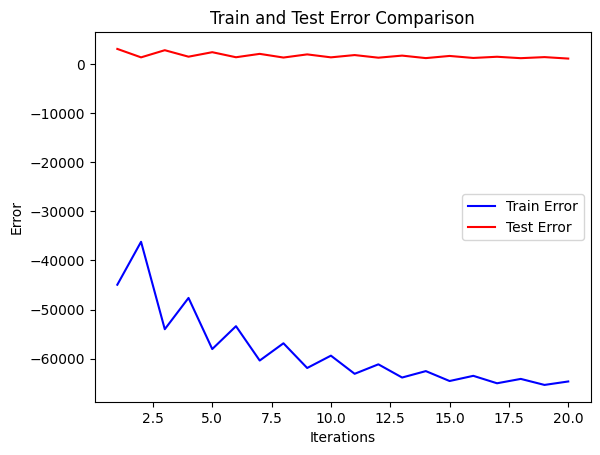

In [ ]:
X = train_df.drop(columns=['IS_BOUND'])  # 特征数据
X = X.drop(columns=['QUOTEDATE'], errors = 'ignore') # 删除时间列
y = train_df['IS_BOUND']  # 目标列
Final_test = test_df.drop(columns=['QUOTEDATE','IS_BOUND'], errors = 'ignore')
# 将数据集拆分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=66)

test_error = []
train_error = []
for i in range(1,21):
  clf = RandomForestClassifier(n_estimators=i, random_state=66)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  y_true = y_test
  accuracy = calculate_profit(y_test, y_pred)
  test_error.append(accuracy)
  cm = confusion_matrix(y_true, y_pred)
  print(cm)
  y_pred = clf.predict(X_train)
  accuracy = calculate_profit(y_train, y_pred)
  train_error.append(accuracy)


x = list(range(1, 21))
print(max(test_error))
# 绘制两条线
plt.plot(x, train_error, label='Train Error', color='blue')  # 绘制训练误差线
plt.plot(x, test_error, label='Test Error', color='red')  # 绘制测试误差线

# 添加标签和标题
plt.xlabel('Iterations')  # x 轴标签
plt.ylabel('Error')  # y 轴标签
plt.title('Train and Test Error Comparison')  # 标题

# 显示图例
plt.legend()

# 显示图形
plt.show()

In [ ]:
clf = RandomForestClassifier(n_estimators=8, random_state=66)
clf.fit(X_train, y_train)
predicted = clf.predict(Final_test)
print(len(predicted))
print(predicted.tolist())

15114
[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

# change loss function

In [ ]:
def calculate_profit(y_true, y_pred):
    profit = 0
    for yt, yp in zip(y_true, y_pred):
        if yp == 1:
            if yt == 1:
                profit += 4.5  # 赚取净利润
            else:
                profit -= 1  # 亏损
    return profit

# 2. 自定义利润评估函数
profit_scorer = make_scorer(calculate_profit, greater_is_better=True)

X = train_df.drop(columns=['IS_BOUND'])  # 特征数据
X = X.drop(columns=['QUOTEDATE'], errors = 'ignore') # 删除时间列
y = train_df['IS_BOUND']  # 目标列
Final_test = test_df.drop(columns=['QUOTEDATE','IS_BOUND'], errors = 'ignore')
# 将数据集拆分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=66)

# 4. 创建决策树分类器
clf = DecisionTreeClassifier(random_state=42)

# 5. 使用 GridSearchCV 调整超参数并最大化利润
param_grid = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 使用 GridSearchCV 进行超参数调优
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=profit_scorer, cv=5)
grid_search.fit(X_train, y_train)

# 6. 输出最佳的超参数和利润得分
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best profit score: {grid_search.best_score_}")

# 7. 获取最佳模型并用其进行预测
best_model = grid_search.best_estimator_

# 在训练集和测试集上进行预测
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# 计算训练集和测试集的总利润
train_profit = calculate_profit(y_train, y_train_pred)
test_profit = calculate_profit(y_test, y_test_pred)

print(f"Train profit: {train_profit}")
print(f"Test profit: {test_profit}")

# 8. 使用最佳模型对新数据进行预测
# 假设你有新的数据需要预测
new_data = Final_test  # 替换为你的新数据
y_new_pred = best_model.predict(new_data)

print(f"Predictions for new data: {y_new_pred}")

Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best profit score: 694.4
Train profit: 31656.5
Test profit: 1478.5
Predictions for new data: [0. 0. 0. ... 0. 0. 0.]


In [ ]:
print(len(y_new_pred))
print(y_new_pred.tolist())

15114
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0

In [ ]:
def calculate_profit(y_true, y_pred):
    profit = 0
    for yt, yp in zip(y_true, y_pred):
        if yp == 1:
            if yt == 1:
                profit += 4.5  # 赚取净利润
            else:
                profit -= 1  # 亏损
    return profit

# 2. 自定义利润的样本权重计算函数
def calculate_sample_weights(y_true, y_pred):
    weights = []
    for yt, yp in zip(y_true, y_pred):
        if yp == 1:
            if yt == 1:
                weights.append(5)  # 赚取净利润 TP
            else:
                weights.append(1)  # 亏损 FP
        else:
          if yt == 1:
            weights.append(5)  # 不做任何调整 TN
          else:
            weights.append(10)  # 不做任何调整 FN
    return np.array(weights)

X = train_df.drop(columns=['IS_BOUND'])  # 特征数据
X = X.drop(columns=['QUOTEDATE'], errors = 'ignore') # 删除时间列
y = train_df['IS_BOUND']  # 目标列
Final_test = test_df.drop(columns=['QUOTEDATE','IS_BOUND'], errors = 'ignore')
# 将数据集拆分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=66)

# 4. 创建决策树分类器
clf = DecisionTreeClassifier(random_state=66)

# 5. 初步训练模型，计算预测值
clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

# 6. 计算训练集和测试集的样本权重
train_weights = calculate_sample_weights(y_train, y_train_pred)
test_weights = calculate_sample_weights(y_test, y_test_pred)

# 7. 使用权重重新训练模型
clf.fit(X_train, y_train, sample_weight=train_weights)

# 8. 在训练集和测试集上预测，并计算利润
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

train_profit = calculate_profit(y_train, y_train_pred)
test_profit = calculate_profit(y_test, y_test_pred)

print(f"Train profit: {train_profit}")
print(f"Test profit: {test_profit}")

# 9. 对新数据进行预测
new_data = Final_test  # 替换为你的新数据
y_new_pred = clf.predict(new_data)

print(f"Predictions for new data: {y_new_pred}")

Train profit: 66586.5
Test profit: 2547.0
Predictions for new data: [1. 0. 0. ... 0. 0. 0.]


In [ ]:
print(len(y_new_pred))
print(y_new_pred.tolist())


15114
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0